In [1]:
from dyadic_fem import *
%matplotlib inline
# Remember: if we want interactive 3D plots use %matplotlib notebook

## First we check our FEM solution against a known analytic solution
Here we solve the problem $$-\nabla \cdot (a(x) \nabla u(x)) = f(x)$$ using FEM, where $a(x)=1$ is constant, with  homogeneous Dirichlet bdry conditions and $f(x) = 1$. This is the Poisson equation and has a known analytic solution, which we check our solution against. 

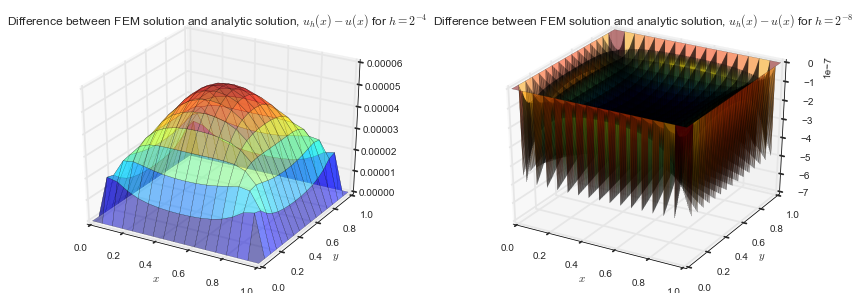

In [2]:
constant_field = DyadicPWConstant(np.ones([2,2]), 1)

fem_coarse = DyadicFEMSolver(div=4, rand_field=constant_field, f=1.0)
fem_fine = DyadicFEMSolver(div=8, rand_field=constant_field, f=1.0)
fem_finer = DyadicFEMSolver(div=9, rand_field=constant_field, f=1.0)

def analytic_soln(x,y,N=16,M=16):
    # This is the standard series solution for the Poisson problem on the unit square 
    # with homogeneous dirichelet boundaries and uniform force f=1
    soln = np.zeros(x.shape)
    for i in range(N):
        for j in range(M):
            n = 2*i+1
            m = 2*j+1
            soln = soln + (4.0 / (math.pi*math.pi*math.pi*math.pi)) * (1.0/(n*m*(n*n + m*m))) * \
                    np.sin(n*math.pi*x) * np.sin(m*math.pi*y)   
    return soln

# Solve both the FEM problems
fem_coarse.solve()
fem_fine.solve()
fem_finer.solve()

analytic_coarse = DyadicPWLinear(func = analytic_soln, div = 4)
analytic_fine = DyadicPWLinear(func = analytic_soln, div = 8)

# Now just plot the difference between the analytic solution and the FEM solution
fig = plt.figure(figsize=(14, 5))

ax = fig.add_subplot(1, 2, 1, projection='3d')
(analytic_coarse - fem_coarse.u).plot(ax, title='Difference between FEM solution and analytic solution, $u_h(x) - u(x)$ for $h=2^{-4}$')

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
(fem_fine.u - fem_finer.u).plot(ax2, title='Difference between FEM solution and analytic solution, $u_h(x) - u(x)$ for $h=2^{-8}$')

plt.show()

We see that the FEM solution on the $2^8$ subdivided square (RHS above) has converged closer to the analytic solution than the $2^4$ subdivided square (LHS above).

# We trust our FEM solution is correct, now we try arbitrary dyadic fields

Here we solve the problem $$-\nabla \cdot (a(x) \nabla u(x)) = f(x)$$ using FEM,where $a(x)$ is a randomly generated piecewise constant function on the dyadic subdivision of the unit square. The field is given by 
$$ a(x) = \bar{a} + c \sum_i y_i \mathbb{1}_{s_i}(x) $$
where $\bar{a}$ and $c$ are constants (given below), $y_i$ is a uniform RV from $[-1,1]$, and $\mathbb{1}_{s_i}$ is the indicator function on the $i$-th dyadic square $s_i$.

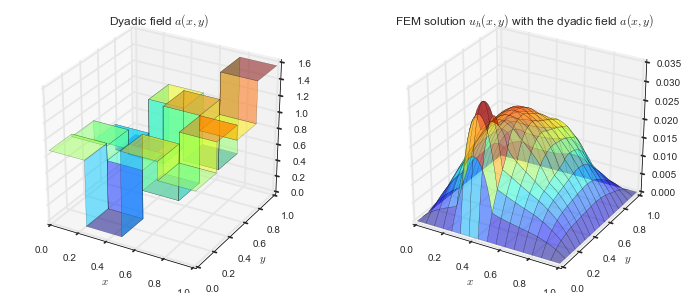

In [3]:
a = make_dyadic_random_field(div=2, a_bar=1.0, c=0.99, seed=2)
fem = DyadicFEMSolver(div=6, rand_field=a, f=1.0)

fem.solve()

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1, projection='3d')
a.plot(ax, title='Dyadic field $a(x,y)$')
ax = fig.add_subplot(1, 2, 2, projection='3d')
fem.u.plot(ax, title='FEM solution $u_h(x,y)$ with the dyadic field $a(x,y)$')
plt.show()

## Test L2 and H1 inner product routines in DyadicPWLinear
We test the $L^2$ and $H^1_0$ norms for functions in $U_h$ (our dyadic triangulation subspace), for a test function $f(x,y) = \sin(\pi x) \sin(\pi y)$, that has known analytic values of $\| f \|_{L^2} = 1/4$ and $\| f \|_{H^1_0} = \pi^2 / 2 + 1/4$

We also test $\langle f, g \rangle_{H_0^1}$ for $f=\sin(\pi x) \sin(\pi y)$ and $g(x,y)=x(1-x)y(1-y)$, which should get us $\langle f, g \rangle_{L^2} = 16 / \pi^6$ and $\langle f, g \rangle_{H_0^1} = 16 / \pi^6 + 32 / \pi^4$

In [8]:
print('Testing convergence of L2 norm to analytic soln of 0.25 \n \
and H1 norm to pi^2 / 2, for increasing dyadic subdiv')

# We define the function we want to creat pw linear approx of...
def f(x,y): return np.sin(math.pi*x) * np.sin(math.pi*y)

for div in range(2,12,2):
    # This will create an interpolated pw-linear function on the dyadic grid of subdivision div
    u = DyadicPWLinear(func = f, div = div)
    
    print('Dyadic lev.', div, '\tL2:', u.dot(u, space='L2'), '\tH1_0:', u.dot(u, space='H1'))
    # NB the L2 norm should be close to (u.values * u.values).sum() / ((2**div+1) * (2**div+1)),

print('Analytic \tL2:', 0.25, '\t\tH1_0:', math.pi * math.pi / 2.0 + 0.25)

# Ok - we do a few more tests to convince ourselves.

print('\nTesting convergence of L2 dot prod to analytic soln of (4/pi^3)^2 \n \
and H1 norm to (4/pi^3)^2 + (32/pi^4), for increasing dyadic subdiv')
# lets try g(x,y) = x * y
def g(x,y): return x * (1-x) * y * (1-y)

print
for div in range(2,12,2):
    # This will create an interpolated pw-linear function on the dyadic grid of subdivision div
    u = DyadicPWLinear(func = f, div = div)
    v = DyadicPWLinear(func = g, div = div)
    
    print('Dyadic lev.', div, '\tL2:', u.dot(v, space='L2'), '\tH1_0:', u.dot(v, space='H1'))
    # NB the L2 norm should be close to (u.values * u.values).sum() / ((2**div+1) * (2**div+1)),

print('Analytic \tL2:', 16.0 /(math.pi**6), 'H1_0:', 16.0/(math.pi**6) + 32.0/(math.pi**4))


Testing convergence of L2 norm to analytic soln of 0.25 
 and H1 norm to pi^2 / 2, for increasing dyadic subdiv
Dyadic lev. 2 	L2: 0.204758898432 	H1_0: 4.89105039945
Dyadic lev. 4 	L2: 0.246812930294 	H1_0: 5.16578114707
Dyadic lev. 6 	L2: 0.249799303156 	H1_0: 5.18361068677
Dyadic lev. 8 	L2: 0.249987450543 	H1_0: 5.18472772037
Dyadic lev. 10 	L2: 0.249999215636 	H1_0: 5.18479754549
Analytic 	L2: 0.25 		H1_0: 5.184802200544679

Testing convergence of L2 dot prod to analytic soln of (4/pi^3)^2 
 and H1 norm to (4/pi^3)^2 + (32/pi^4), for increasing dyadic subdiv
Dyadic lev. 2 	L2: 0.0135854980615 	H1_0: 0.324515106446
Dyadic lev. 4 	L2: 0.0164302151431 	H1_0: 0.343883505323
Dyadic lev. 6 	L2: 0.016629222312 	H1_0: 0.345074679553
Dyadic lev. 8 	L2: 0.016641748148 	H1_0: 0.345149057487
Dyadic lev. 10 	L2: 0.0166425313573 	H1_0: 0.345153705834
Analytic 	L2: 0.01664258357273364 H1_0: 0.34515401572263243


## Now we look at coarse grid approximations, where $V_n$ is the space of $n$ coarse grid hat functions
This code computes an FEM solution $u_h$ from $a$. We have a full set of coarse grid hat functions $V_n = \{ v_1, v_2, \ldots, v_n\}$, i.e. $n = (2^d-1) \times (2^d - 1)$ where $d = \mathtt{coarse\_div}$, the dyadic level of the coarse grid, that is we have a hat function for every possible point in the grid that is not on the boundary. We compute the set of inner products $$w_i = \langle v_i, u_h \rangle$$ 
where the inner product is both the $L^2$ and $H^1_0$ inner product. $V_n$ is not orthonormal, so we must do some linear algebra...

We reconstruct the function by computing the matrix $\mathbf{\Phi}$, where $$\Phi_{i,j} = \langle v_i, v_j \rangle$$ and we then solve the system $$\mathbf{\Phi} \mathbf{y} = \mathbf{w}$$ where $\mathbf{w}$ is the vector with values $w_i$. We solve for $\mathbf{y}$, and our reconstruction is then $$\hat{u}_h(x) = \sum_{i=1}^n y_i v_i(x)$$ which we plot and look at the differences. This reconstruction should be $\hat{u}_h = P_{V_n} u_h$, where $P_{V_n}$ is the projection operator.

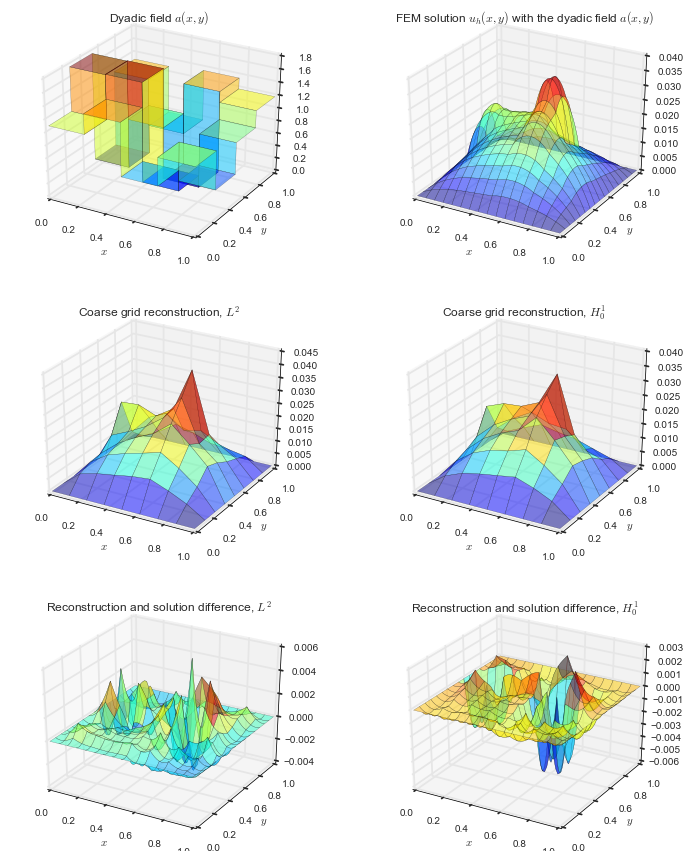

In [5]:
# The dyadic divisino levels for the random field, the FEM solution, and the
# approximate solution space v_n
field_div = 2
fem_div = 6
coarse_div = 3

a = make_dyadic_random_field(div=field_div, a_bar=1.0, c=0.99, seed=3)
fem = DyadicFEMSolver(div=fem_div, rand_field=a, f=1.0)

fem.solve()
V_n = []
# n is the number of internal coarse grid points, i.e. we will have n different hat functionsdd
# for our coarse-grid basis
n = (2**coarse_div-1) * (2**coarse_div-1)
side_n = 2**coarse_div-1

Phi_L2 = np.zeros([n, n])
Phi_H1 = np.zeros([n, n])
w_L2 = np.zeros(n)
w_H1 = np.zeros(n)
for k in range(side_n):
    for l in range(side_n):
        v_i = DyadicPWLinear(div = coarse_div)
        v_i.values[k+1, l+1] = 1.0
        V_n.append(v_i)
        
        # Now we take the L2 / H1_0 dot product between this and the FEM soln
        w_H1[side_n * k + l] = fem.u.dot(v_i, space='H1')
        w_L2[side_n * k + l] = fem.u.dot(v_i, space='L2')
        
        # And build the co-dependence matrix at the same time...
        for k2 in range(side_n):
            for l2 in range(side_n):
                v_j = DyadicPWLinear(div = coarse_div)
                v_j.values[k2+1,l2+1] = 1.0
                
                Phi_L2[side_n * k + l, side_n * k2 + l2] = v_i.dot(v_j, space='L2')
                Phi_H1[side_n * k + l, side_n * k2 + l2] = v_i.dot(v_j, space='H1')

# Now we get the coefficients by solving the linear system (BTW We'll do this in the next section with Gram-Schmidt/
# QR factorisation... much easier and quicker...)
y_L2 = np.linalg.solve(Phi_L2, w_L2)
y_H1 = np.linalg.solve(Phi_H1, w_H1)

u_hat_L2 = DyadicPWLinear(div = coarse_div)
u_hat_H1 = DyadicPWLinear(div = coarse_div)

# We can put these values straight in to the pw linear function as our v_i are just hat functions...
u_hat_L2.values[1:-1,1:-1] = y_L2.reshape([side_n, side_n])
u_hat_H1.values[1:-1,1:-1] = y_H1.reshape([side_n, side_n])

fig = plt.figure(figsize=(12, 15))

ax = fig.add_subplot(3, 2, 1, projection='3d')
a.plot(ax, title='Dyadic field $a(x,y)$')

ax = fig.add_subplot(3, 2, 2, projection='3d')
fem.u.plot(ax, title='FEM solution $u_h(x,y)$ with the dyadic field $a(x,y)$')

ax = fig.add_subplot(3, 2, 3, projection='3d')
u_hat_L2.plot(ax, title='Coarse grid reconstruction, $L^2$')

ax = fig.add_subplot(3, 2, 4, projection='3d')
u_hat_H1.plot(ax, title='Coarse grid reconstruction, $H^1_0$')

ax = fig.add_subplot(3, 2, 5, projection='3d')
(u_hat_L2 - fem.u).plot(ax, title='Reconstruction and solution difference, $L^2$')

ax = fig.add_subplot(3, 2, 6, projection='3d')
(u_hat_H1 - fem.u).plot(ax, title='Reconstruction and solution difference, $H^1_0$')

plt.show()

## Now we do the same but by first constructing an orthonormal basis from our set $V_n$

The method here is a bit of a hack because there is no built in Gram-Schmidt operation in NumPy. We use the Cholesky factorisation followed by an upper triangular inversion to get us a quick and stable orthogonalisation of the basis functions.

I.e. if we have $\Phi_{i,j} = \langle \phi_i, \phi_j \rangle$, and we want to find $\tilde{\phi}_i(x) = \sum_j G_{i,j} \phi_j(x)$ such that $\tilde{\Phi}_{i,j} = \langle \tilde\phi_i, \tilde\phi_j \rangle = \delta_{i,j}$. This means that 
$$ \tilde{\Phi}_{i,j} = \left\langle\sum_k G_{i,k} \phi_k, \sum_\ell G_{j,\ell} \phi_\ell\right\rangle
= \sum_k \sum_\ell G_{i,k}  G_{j,\ell} \langle \phi_k, \phi_\ell \rangle = \mathbf{G} \mathbf{\Phi} \mathbf{G}^T = \mathbf{I}$$
from which we see that we want to find $\mathbf{G}$ such that $\mathbf{\Phi} = \mathbf{G}^{-1} (\mathbf{G}^T)^{-1} = \mathbf{G}^{-1} (\mathbf{G}^{-1})^T$. It is well known that a triangular matrix has a triangular inverse, thus we simply want to find the Cholesky decomposition (as we know that $\mathbf{\Phi}$ is symmetric and positive definite)
$$ \mathbf{\Phi} = \mathbf{L}\mathbf{L}^T$$
then we simply find $\mathbf{G} = \mathbf{L}^{-1}$, which is done in LAPACK using a backward substitution algorithm.

First few dot products
( i , j )	<V*i,V*j>_L2	 <V*i,V*j>_H1
( 0 , 0 )	 1.0 		 1.0
( 0 , 1 )	 0.0 		 0.0
( 0 , 2 )	 -0.0 		 0.0
( 1 , 0 )	 0.0 		 0.0
( 1 , 1 )	 1.0 		 1.0
( 1 , 2 )	 0.0 		 -0.0
( 2 , 0 )	 -0.0 		 0.0
( 2 , 1 )	 0.0 		 -0.0
( 2 , 2 )	 1.0 		 1.0


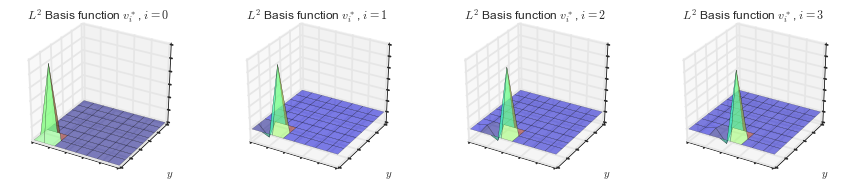

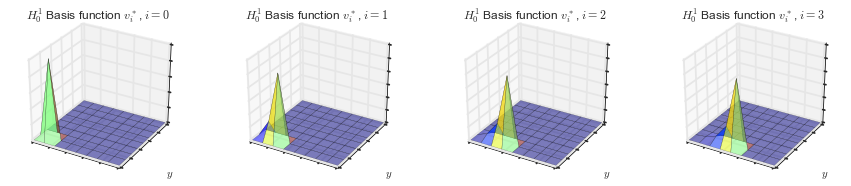

In [6]:
# We use the same parameters and Phi as in the last section.
L_L2 = np.linalg.cholesky(Phi_L2)
L_H1 = np.linalg.cholesky(Phi_H1)

# Ok - this was only found experimentally....
# We need an UPPER triangular matrix for the dtrtri() routine *I think*, so it wasn't inversing this properly before
# when I wasn't taking the transpose. SO, now it inverses correctly, and this gives us something that works.
L_L2_inv = scipy.linalg.lapack.dtrtri(L_L2.T)[0]
L_H1_inv = scipy.linalg.lapack.dtrtri(L_H1.T)[0]

Vstar_n_L2 = []
Vstar_n_H1 = []
for i in range(n):
    Vstar_n_L2.append(DyadicPWLinear(values = np.pad(L_L2_inv[:,i].reshape(side_n,side_n), ((1,1),(1,1)), 'constant')))
    Vstar_n_H1.append(DyadicPWLinear(values = np.pad(L_H1_inv[:,i].reshape(side_n,side_n), ((1,1),(1,1)), 'constant')))

print('First few dot products\n( i , j )\t<V*i,V*j>_L2\t <V*i,V*j>_H1')
for i in range(3):
    for j in range(3):
        print('(', i, ',', j, ')\t', Vstar_n_L2[i].dot(Vstar_n_L2[j], space='L2').round(2),'\t\t', Vstar_n_H1[i].dot(Vstar_n_H1[j], space='H1').round(2))


show = 4
fig = plt.figure(figsize=(15, 3))
for i, vec in enumerate(Vstar_n_L2[:show]):
    ax = fig.add_subplot(1, show, i+1, projection='3d')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    #sin_ortho_basis.vecs[i].plot(ax, show_axes_labels=False)
    Vstar_n_L2[i].plot(ax, title='$L^2$ Basis function $v^*_i$, $i={0}$'.format(i))
plt.show()

fig = plt.figure(figsize=(15, 3))
for i, vec in enumerate(Vstar_n_H1[:show]):
    ax = fig.add_subplot(1, show, i+1, projection='3d')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    #sin_ortho_basis.vecs[i].plot(ax, show_axes_labels=False)
    Vstar_n_H1[i].plot(ax, title='$H^1_0$ Basis function $v^*_i$, $i={0}$'.format(i))
plt.show()

#fig = plt.figure(figsize=(15, 10))
#for i in range(10,16):
#    ax = fig.add_subplot(2, 3, i-9, projection='3d')
#plt.show()

#fig = plt.figure(figsize=(15, 10))
#for i in range(10,16):
#    ax = fig.add_subplot(2, 3, i-9, projection='3d')
#    Vstar_n_H1[i].plot(ax, title='$H^1_0$ Basis function $v^*_i$, $i={0}$'.format(i))
    
#plt.show()

## Now I've abstracted this code in to a _Basis_ class, here we test it

Total difference between orthonormalised basis, manual vs class method, L2 and H1
Ortho vec 0 L2: 0.0 H1: 0.0
Ortho vec 1 L2: 0.0 H1: 0.0
Ortho vec 2 L2: 0.0 H1: 0.0
Ortho vec 3 L2: 0.0 H1: 0.0
Ortho vec 4 L2: 0.0 H1: 0.0
Ortho vec 5 L2: 0.0 H1: 0.0
Ortho vec 6 L2: 0.0 H1: 0.0
Ortho vec 7 L2: 0.0 H1: 0.0


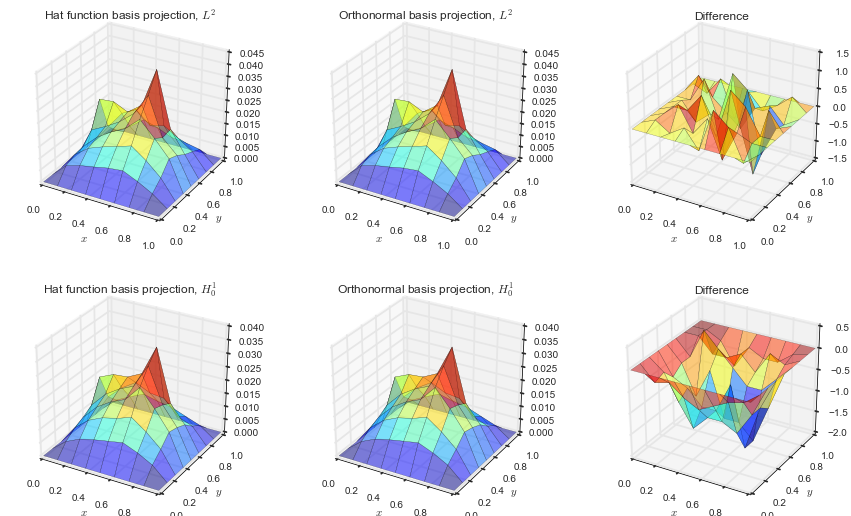

In [7]:
hat_basis_L2 = Basis(V_n, space='L2')
hat_basis_H1 = Basis(V_n, space='H1')

# Doing an orthogonal projection is as simple as...
u_p_L2 = hat_basis_L2.project(fem.u)
u_p_H1 = hat_basis_H1.project(fem.u)

# Similarly, orthonormalising is as simple as...
ortho_hat_basis_L2 = hat_basis_L2.orthonormalise()
ortho_hat_basis_H1 = hat_basis_H1.orthonormalise()

# Now lets just double check that we've done things right:

# Compare the projection to the previous results. u_hat_L2 is the projection from previous code
%matplotlib inline

# Compare the orthonormal basis to the previous results:
print('Total difference between orthonormalised basis, manual vs class method, L2 and H1')
for i in range(8):
    print('Ortho vec {0} L2:'.format(i), (Vstar_n_L2[i] - ortho_hat_basis_L2.vecs[i]).norm(), 'H1:', (Vstar_n_H1[i] - ortho_hat_basis_H1.vecs[i]).norm())

# Make sure our orthonormal projection is the same as the original basis projection:
%matplotlib inline
fig = plt.figure(figsize=(15, 9))

ax = fig.add_subplot(2, 3, 1, projection='3d')
u_p_L2.plot(ax, title='Hat function basis projection, $L^2$')

ax = fig.add_subplot(2, 3, 2, projection='3d')
ortho_hat_basis_L2.project(fem.u).plot(ax, title='Orthonormal basis projection, $L^2$')

ax = fig.add_subplot(2, 3, 3, projection='3d')
(u_p_L2 - ortho_hat_basis_L2.project(fem.u)).plot(ax, title='Difference')

ax = fig.add_subplot(2, 3, 4, projection='3d')
u_p_H1.plot(ax, title='Hat function basis projection, $H^1_0$')

ax = fig.add_subplot(2, 3, 5, projection='3d')
ortho_hat_basis_H1.project(fem.u).plot(ax, title='Orthonormal basis projection, $H^1_0$')

ax = fig.add_subplot(2, 3, 6, projection='3d')
(u_p_H1 - ortho_hat_basis_H1.project(fem.u)).plot(ax, title='Difference')

plt.show()


The difference plots are of the order of $10^{-16}$, i.e. machine precision (multiplier is missing from the axis for some reason...)

### Now lets look at the sinusoid basis and see how well it approximates our solutions...

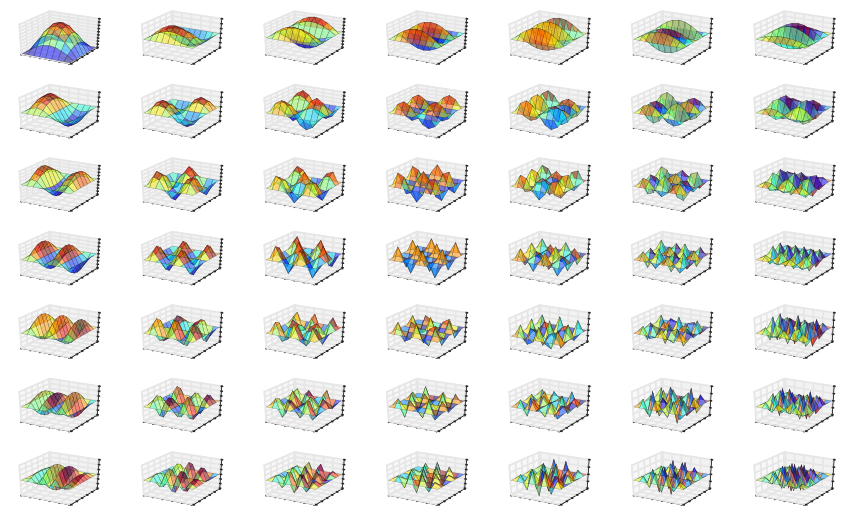

maximum difference between hat and sin projection: 1.38777878078e-17


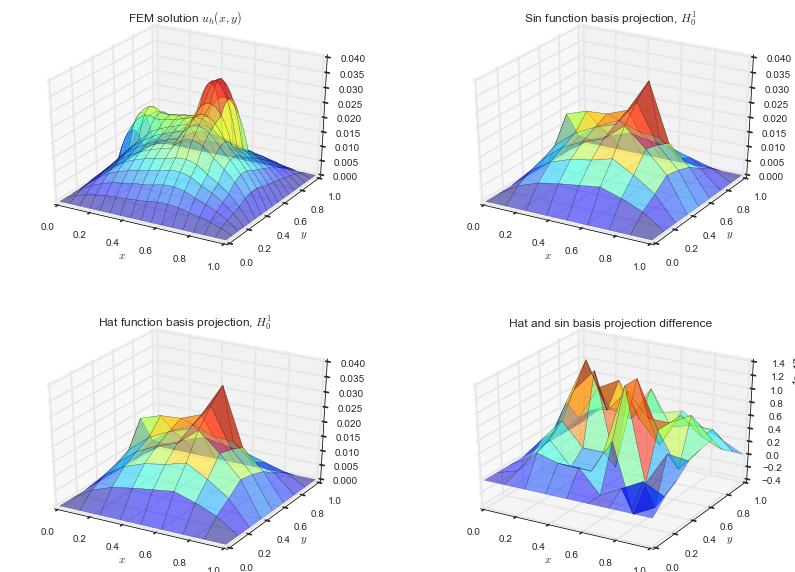

In [8]:
div = 3
n = 2**div-1

sin_basis = make_sin_basis(div=div, N=n, space='H1')
hat_basis = make_hat_basis(div=div, space='H1')

sin_ortho_basis = sin_basis.orthonormalise()
hat_ortho_basis = hat_basis.orthonormalise()

fig = plt.figure(figsize=(15, 9))
for i, vec in enumerate(sin_ortho_basis.vecs):
    ax = fig.add_subplot(n, n, i+1, projection='3d')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    sin_ortho_basis.vecs[i].plot(ax, show_axes_labels=False)
plt.show()

u_sin = sin_ortho_basis.project(fem.u)
u_hat = hat_ortho_basis.project(fem.u)

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(2, 2, 1, projection='3d')
fem.u.plot(ax, title='FEM solution $u_h(x,y)$')

ax = fig.add_subplot(2, 2, 2, projection='3d')
u_sin.plot(ax, title='Sin function basis projection, $H^1_0$')
ax = fig.add_subplot(2, 2, 3, projection='3d')
u_hat.plot(ax, title='Hat function basis projection, $H^1_0$')
ax = fig.add_subplot(2, 2, 4, projection='3d')
(u_sin - u_hat).plot(ax, title='Hat and sin basis projection difference')

print('maximum difference between hat and sin projection:', (u_sin - u_hat).values.max())

We see that the hat function and sin functions give the same projection (the difference in bottom right is of the order of $10^{-17}$) as they are both complete bases for the space of dyadic piece-wise linear functions on the dyadic grid.
## Now we try a more methodically created basis of FEM solutions

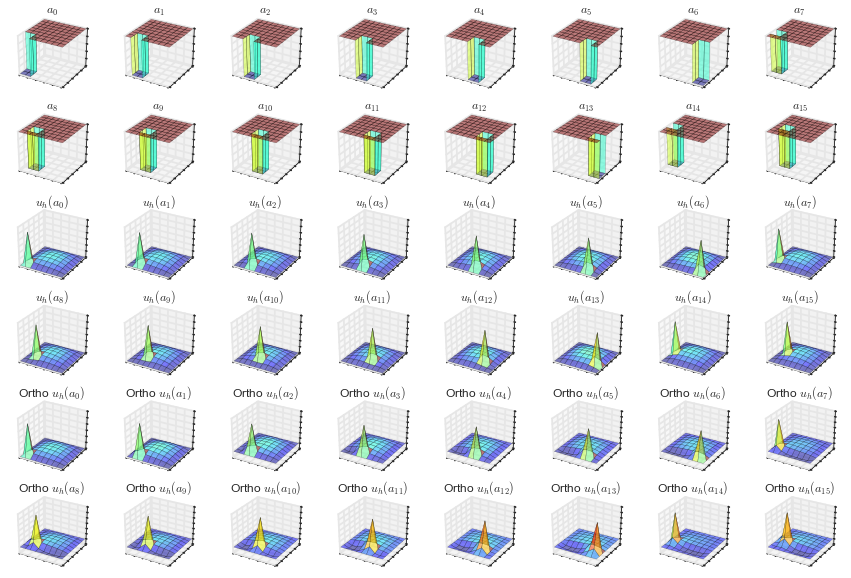

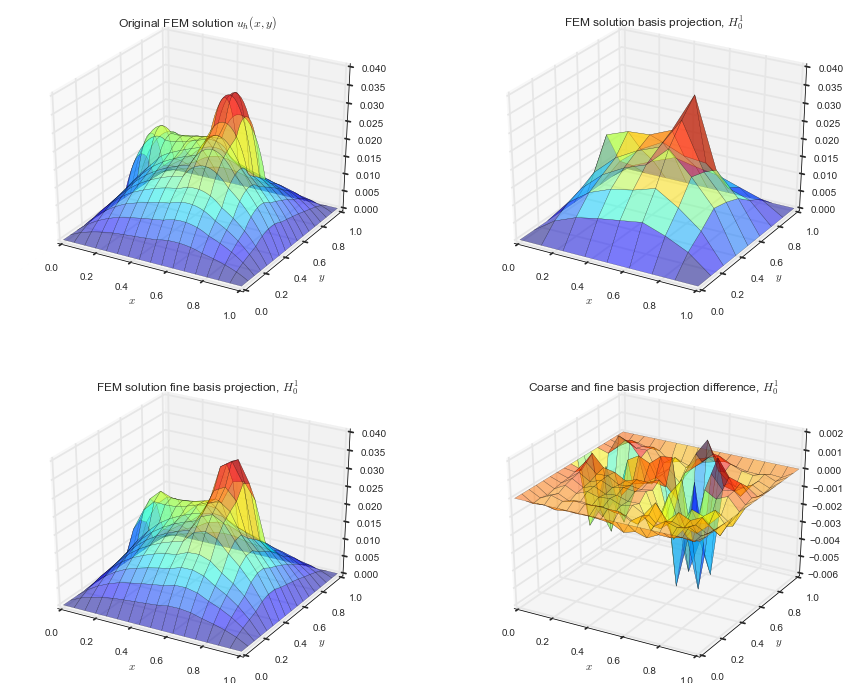

In [11]:
fem_div = 3

np.random.seed(3)
fem_basis, fields = make_approx_basis(div=fem_div, space='H1')
fem_ortho_basis = fem_basis.orthonormalise()

fine_fem_div = 4
fine_fem_basis, fine_fields = make_approx_basis(div=fine_fem_div, space='H1')
fine_fem_ortho_basis = fine_fem_basis.orthonormalise()

# There should be 16 fields and 16 solutions.... split in to rows of 8
fig = plt.figure(figsize=(15, 10))
for i, vec in enumerate(fem_basis.vecs[:16]):
    ax = fig.add_subplot(6, 8, i+1, projection='3d')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    fields[i].plot(ax, title='$a_{{{0}}}$'.format(i), show_axes_labels=False)
    
    ax = fig.add_subplot(6, 8, i+1+16, projection='3d')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    fem_basis.vecs[i].plot(ax, title='$u_h(a_{{{0}}})$'.format(i), show_axes_labels=False)

    ax = fig.add_subplot(6, 8, i+1+2*16, projection='3d')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    fem_ortho_basis.vecs[i].plot(ax, title='Ortho $u_h(a_{{{0}}})$'.format(i), show_axes_labels=False)

plt.show()

# Now lets try projecting another solution to this basis...
u_approx = fem_ortho_basis.project(fem.u)
u_approx_fine = fine_fem_ortho_basis.project(fem.u)

fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(2, 2, 1, projection='3d')
fem.u.plot(ax, title='Original FEM solution $u_h(x,y)$')
ax = fig.add_subplot(2, 2, 2, projection='3d')
u_approx.plot(ax, title='FEM solution basis projection, $H^1_0$')
ax = fig.add_subplot(2, 2, 3, projection='3d')
u_approx_fine.plot(ax, title='FEM solution fine basis projection, $H^1_0$')
ax = fig.add_subplot(2, 2, 4, projection='3d')
(u_approx - u_approx_fine).plot(ax, title='Coarse and fine basis projection difference, $H^1_0$')


## Ok one last test - of the dyadic PW linear with PW constant dot product test....

In [12]:
pwc = DyadicPWConstant(div = 2)
pwl = DyadicPWLinear(div = 3)

pwc.values[0,0] = 0.5
pwl.values[1,1] = 1.0

print(pwc.dot(pwl))
# This is the value that should come out...
print(0.5 / (2*2**3*4))

0.0078125
0.0078125


### Does the interpolation work as expected?

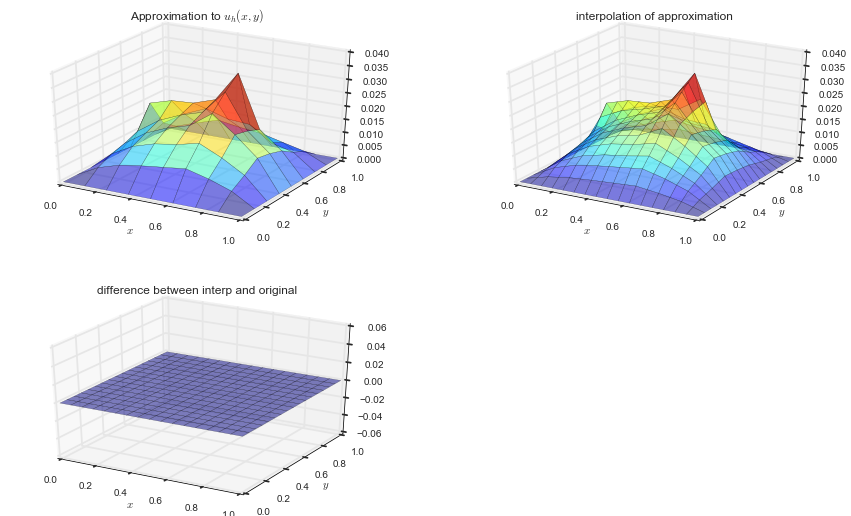

In [13]:
fig = plt.figure(figsize=(15, 9))
ax = fig.add_subplot(2, 2, 1, projection='3d')
u_approx.plot(ax, title='Approximation to $u_h(x,y)$')
ax = fig.add_subplot(2, 2, 2, projection='3d')
u_approx.interpolate(6).plot(ax, title='interpolation of approximation')
ax = fig.add_subplot(2, 2, 3, projection='3d')
(u_approx.interpolate(6) - u_approx).plot(ax, title='difference between interp and original')
plt.show()

### Does the DyadicPWHybrid class and plot work properly?

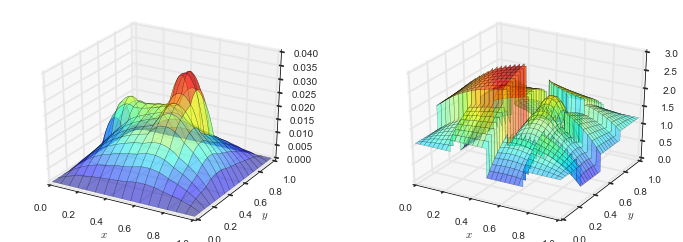

In [14]:
# The actual reconstruction requires a new hybrid
# PW Constant + Linear function
# which we quickly test here...

%matplotlib inline
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(2, 2, 1, projection='3d')
fem.u.plot(ax)
ax = fig.add_subplot(2, 2, 2, projection='3d')
(a + (2*fem.u/fem.u.values.max())).plot(ax)

### Make $H_0^1$ representers for integration in a dyadic cube
Which we do by solving the equation $\mathbf{G} v = \ell(f)$, where $\ell(f)$ is the linear functional (here a measurement), and $v$ is the representer of that measurement that we want to take, and $\mathbf{G}$ is the Grammian for the hat function basis in $H_0^1$.

integral of random function : 0.016920308067533748
dot prod of v with function : 0.016920308067533734
dot prod basis_meas[i] with function : 0.016920308067533734


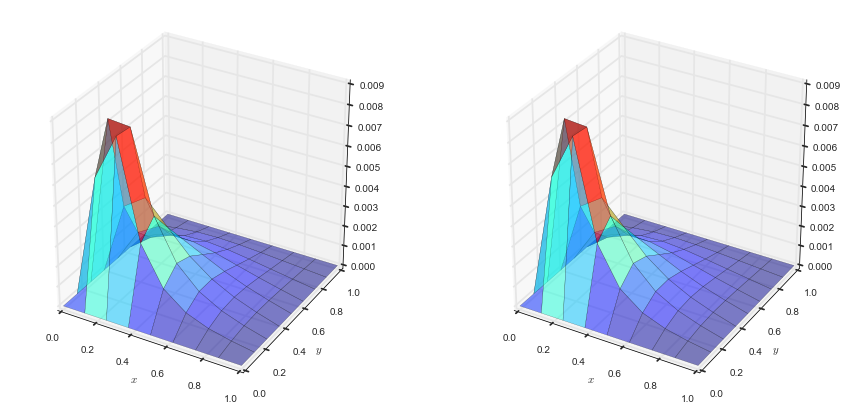

In [23]:
coarse_div = 3
h = 1.0 / (2**coarse_div)
n_side = 2**coarse_div - 1
n = n_side * n_side

hat_b = make_hat_basis(div=coarse_div, space='H1')

meas = [0,0]

# This integration vector will give us the integral of a PW linear func on the triangulation
# by simply computing func_vec.dot(int_vec)
int_vec = np.zeros(n)
int_vec[meas[1]*n_side+meas[0]] = h*h / 2
int_vec[meas[1]*n_side+meas[0]+1] = h*h
int_vec[(meas[1]+1)*n_side+meas[0]] = h*h
int_vec[(meas[1]+1)*n_side+meas[0]+1] = h*h / 2

hat_b.make_grammian()

# Now to find the representer that gets us this....
v = np.linalg.solve(hat_b.G, int_vec)

# Now lets see what it looks like!
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(1, 2, 1, projection='3d')
hat_b.reconstruct(v).plot(ax)

# Now we do it in code
Mn = make_local_integration_basis(div=coarse_div, int_div=coarse_div, space='H1')
ax = fig.add_subplot(1, 2, 2, projection='3d')
Mn.vecs[0].plot(ax)

# Now lets try a bunch of random functions and see if we get the right thing...
rand_func_vec = np.random.random(n)
rand_func = hat_b.reconstruct(rand_func_vec)
#ax = fig.add_subplot(1, 2, 2, projection='3d')
#rand_func.plot(ax)

print('integral of random function : {0}'.format(rand_func_vec.dot(int_vec)))
print('dot prod of v with function : {0}'.format(hat_b.reconstruct(v).dot(rand_func, space='H1')))
print('dot prod basis_meas[i] with function : {0}'.format(Mn.vecs[0].dot(rand_func, space='H1')))